In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
from sqlalchemy import create_engine
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker

import warnings
warnings.filterwarnings("ignore")

def get_engine(db_name):
    if db_name == 'antares':
        user='k.mekhtiev'
        password='Geehu8kie8heo7aikohquohkeiX3Oa'
        host='10.250.201.21'
        engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{db_name}')
    elif db_name == 'dwh':
        user='k.mekhtiev'
        password='fsOwuFsj1XIU'
        host='10.250.201.241'
        dbname='dwh'
        engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{db_name}')
    return engine
        



def execute(SQL, db_name = 'dwh'):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(db_name)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = end_time - start_time  # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    return df
    

In [2]:
begin_date = datetime.strptime('2024-04-10', '%Y-%m-%d')
end_date = datetime.strptime('2024-04-16', '%Y-%m-%d')
cuped_date = begin_date - timedelta(days = 7) 


query =f''' SELECT
                    date_msk,
                    lower(device_id) AS device_id,
                    CASE WHEN profile_uuid IS NOT NULL THEN 'Зарег' ELSE 'Незарег' END profile_type,
                    score_str,
                    client AS os_name,
                    bot_flag,
                    sum(ttl_depth_ms)/1000 AS watchtime,
                    count(DISTINCT date_msk)  AS cnt_day
                    FROM dds.fct_dds_backend_streams_watchtime_by_user
                    WHERE reference=1 AND date_msk BETWEEN '{cuped_date}' AND '{end_date}'
                    GROUP BY 1,2,3,4,5,6

                    '''

df_watchtime = execute(query,db_name='dwh')
df_watchtime['date_msk'] = df_watchtime['date_msk'].astype('datetime64[ns]')
df_watchtime = df_watchtime.dropna(subset=['watchtime'])
df_watchtime['watchtime'] = df_watchtime['watchtime'].astype('float')

Время выполнения функции: 8.975752353668213 секунд


In [3]:
query2 =  f''' SELECT  
                    yappy_device_uuid::TEXT,
                    max(os_name) AS os_name,
                    max(device_manufacturer) AS device_manufacturer,
                    max(country_type) AS  country_type,
                    max(device_model) AS device_model,
                    max(app_version_name) AS app_version_name
                    FROM dds.fct_dds_clear_appm_events
                    WHERE event_date_msk BETWEEN '{cuped_date}' AND '{end_date}'
                    AND event_name IN ('video_visible','video_watch','video_watched','video_add_like','video_add_comment','video_share')
                    AND reference='tape'
                    group by 1
                    '''

df_appmetrica = execute(query2,db_name='dwh')

Время выполнения функции: 21.658643007278442 секунд


In [4]:
query3 = f''' SELECT yappy_device_uuid::TEXT FROM dds.fct_dds_appm_first_event_device_uuid_app_open
                   WHERE event_date_msk BETWEEN '{cuped_date}' AND '{end_date}'
                    '''

df_new_user = execute(query3,db_name='dwh')

Время выполнения функции: 1.467519760131836 секунд


# Код для просмотра watchtime за неделю 

In [ ]:
# list_date = pd.date_range('2024-01-01', '2024-02-22', freq='D')

In [ ]:
# import psycopg2
# connection =psycopg2.connect(
#                              database="dwh",
#                              host="10.250.201.241",
#                              password="fsOwuFsj1XIU",
#                              port="5432",
#                              user="k.mekhtiev",
#                              ) 
# with connection.cursor() as cursor:
#     for date in list_date:
#             query_delete = f"delete from sandbox.mekhtiev_watcthime_7_days where date_msk = '{date}'"
#             cursor.execute(query_delete)
#             print(f'Дата {date} удалена из таблицы')
#             query = f"""INSERT INTO sandbox.mekhtiev_watcthime_7_days
#                             SELECT 
#                                 '{date}'::date AS date_msk,
#                                  CASE WHEN profile_uuid IS NULL THEN 0 ELSE 1 END AS profile_type,
#                                  sum(CASE WHEN date_msk<'2024-01-18' THEN  ttl_depth*1000 ELSE ttl_depth_ms END)/1000 AS watchtime,
#                                  sum(cnt_video) AS broadcast,
#                                  count(distinct device_id) AS cnt_user 
#                             FROM dds.fct_dds_backend_streams_watchtime_by_user
#                             WHERE 
#                                reference=1 AND bot_flag=0 AND  date_msk BETWEEN '{date}'::date - interval '6' DAY AND '{date}'::date
#                                group by 1,2"""
#             cursor.execute(query)
#             print(f'Дата {date} загружена в таблицу') 

# connection.commit()
# connection.close()

# Объединим фреймворки

In [5]:
df_watchtime_merge = (pd.merge(df_watchtime,
                              df_appmetrica[['yappy_device_uuid','device_manufacturer','country_type','device_model','app_version_name']],
                              right_on='yappy_device_uuid',left_on='device_id',how='left')
                              [['date_msk','device_id','profile_type','os_name','score_str','bot_flag','device_manufacturer','country_type','device_model','app_version_name','watchtime']]
                     )
df_watchtime_merge

,date_msk,device_id,profile_type,os_name,score_str,bot_flag,device_manufacturer,country_type,device_model,app_version_name,watchtime
0,2024-04-11,fd9e7893-1afa-3881-a657-42a96343d859,Незарег,1,ok,0,Infinix,Россия,Infinix X6831,1.49.0,58.750
1,2024-04-11,265f07b2-31a7-3274-8f82-cbecee98d7ee,Зарег,1,low,0,Tecno,Россия,TECNO POVA 4 Pro,1.50.1,2069.876
2,2024-04-11,7436ad48-f683-3620-bf37-f675878ab52c,Незарег,1,low,0,Samsung,Россия,Galaxy M01s,1.53.0,8.984
3,2024-04-11,ae8a3914-d473-31e2-b30e-9eb742a39b62,Незарег,1,low,0,Redmi,Россия,Redmi 9C NFC,1.49.0,0.509
4,2024-04-11,086aa788-9760-445f-82bf-01b152ee8d03,Зарег,0,None,0,Apple,Россия,iPhone 13 Pro,1.54.0,1.002
...,...,...,...,...,...,...,...,...,...,...,...
1297227,2024-04-07,7069d449-3fb0-36e9-8186-4f04700ade31,Незарег,1,low,0,Realme,Россия,realme 10,1.49.0,0.000
1297228,2024-04-07,b56002e3-b9d4-3519-9beb-d3bcd5170fdb,Незарег,1,low,0,Redmi,Россия,Redmi 9C NFC,1.49.0,1599.690
1297229,2024-04-09,f0d7cabe-c244-3772-81b8-0c55c165be53,Незарег,1,low,0,Xiaomi,Россия,Mi 10i,1.49.0,284.433
1297230,2024-04-07,c0a7ff79-3f04-34aa-93b7-0728d8de7611,Незарег,1,low,0,Oppo,Россия,A52 中国版,1.49.0,19.845


In [6]:
df_watchtime_merge = (pd.merge(df_watchtime_merge,
                              df_new_user,
                              right_on='yappy_device_uuid',left_on='device_id',how='left',indicator='new_type')
                              [['date_msk','device_id','profile_type','os_name','score_str','bot_flag','device_manufacturer','country_type','device_model','watchtime','new_type','app_version_name']]
                     )
df_watchtime_merge['new_type'].replace({'left_only':'Удержанные','right_only':'Удержанные','both':'Новые'},inplace=True)
df_watchtime_merge['new_type'] = df_watchtime_merge['new_type'].astype('object')


In [7]:
# Проверка долей в разных срезах
checking = df_watchtime_merge[(df_watchtime_merge['date_msk']>=begin_date) & (df_watchtime_merge['date_msk']<=end_date) & (df_watchtime_merge['bot_flag']==0)].groupby(['profile_type','new_type'])['device_id'].nunique().reset_index()
checking['frac'] = checking['device_id'] / checking.groupby('profile_type')['device_id'].transform('sum')
checking

,profile_type,new_type,device_id,frac
0,Зарег,Новые,27305,0.369036
1,Зарег,Удержанные,46685,0.630964
2,Незарег,Новые,212996,0.664968
3,Незарег,Удержанные,107314,0.335032


## Число бакетов в тесте, % namespace и % события experiment_empty

In [8]:
num_of_bucket = 2
namespace = 1 # процент пользователей в тесте от всех пользователей 
gb_split = 0.55 # процент пользователей, кто получает событие experiment_empty  от всех тех, кто получил группу эксперимента

### Функция для сегментации 

In [9]:
def segment(df, type, pre_experimental_week):
    if type == 'Все пользователи' and pre_experimental_week == 'not_required':
        return df[(df['date_msk'] >= begin_date) & (df['date_msk'] <= end_date) & (df['bot_flag'] == 0) & (~df['score_str'].isin(['mid', 'high'])) & (df['app_version_name'] != '1.49.0')]
    elif type == 'Все пользователи' and pre_experimental_week == 'required':
        return df[(df['date_msk'] >= cuped_date) & (df['date_msk'] < begin_date) & (df['bot_flag'] == 0) & (~df['score_str'].isin(['mid', 'high'])) & (df['app_version_name'] != '1.49.0')]
    
    elif type == 'Зареги' and pre_experimental_week == 'not_required':
        return df[(df['date_msk'] >= begin_date) & (df['date_msk'] <= end_date) & (df['bot_flag'] == 0) & (~df['score_str'].isin(['mid', 'high'])) & (df['profile_type'] == 'Зарег') & (df['app_version_name'] != '1.49.0')]
    elif type == 'Зареги' and pre_experimental_week == 'required':
        return df[(df['date_msk'] >= cuped_date) & (df['date_msk'] < begin_date) & (df['bot_flag'] == 0) & (~df['score_str'].isin(['mid', 'high'])) & (df['profile_type'] == 'Зарег') & (df['app_version_name'] != '1.49.0')]
    
    elif type == 'Незареги' and pre_experimental_week == 'not_required':
        return df[(df['date_msk'] >= begin_date) & (df['date_msk'] <= end_date) & (df['bot_flag'] == 0) & (~df['score_str'].isin(['mid', 'high'])) & (df['profile_type'] == 'Незарег') & (df['app_version_name'] != '1.49.0')]
    elif type == 'Незареги' and pre_experimental_week == 'required':
        return df[(df['date_msk'] >= cuped_date) & (df['date_msk'] < begin_date) & (df['bot_flag'] == 0) & (~df['score_str'].isin(['mid', 'high'])) & (df['profile_type'] == 'Незарег') & (df['app_version_name'] != '1.49.0')]
    else:
        return df

## Выбираем сегмент ("Все пользователи"/"Зареги"/"Незареги")

In [10]:
df_watchtime_2 = segment(df_watchtime_merge,type = 'Все пользователи',pre_experimental_week = 'not_required')
df_watchtime_agg = df_watchtime_2.groupby(['device_id','os_name','device_manufacturer','country_type','device_model','new_type','app_version_name'])['watchtime'].sum().reset_index()

In [11]:
quantiles=[1,2,3,4,5,6,7,8,9,10,25,50,75,80,85,90,91,92,93,94,95,96,97,98,99]
columns = ['watchtime']


# пустой df для хранения результатов
quantiles_data = pd.DataFrame(index=quantiles, columns=columns)

for i in columns:
    data = df_watchtime_agg[i].dropna()
    quantile_values = np.percentile(data, quantiles)
    quantiles_data[i] = quantile_values

print(quantiles_data)
print()
print('Дисперсия watchtime:',round(df_watchtime_agg['watchtime'].var()))
print('Число пользователей:',round(df_watchtime_agg['device_id'].nunique()))
print('Средний watchtime, мин:',round(df_watchtime_agg['watchtime'].mean()/60,3))

     watchtime
1      0.00000
2      0.00000
3      0.00000
4      0.00000
5      0.00000
6      0.00000
7      0.00000
8      0.00000
9      0.00000
10     0.03200
25     3.80300
50    30.33800
75   196.89900
80   305.44760
85   379.32980
90   431.31300
91   458.31336
92   498.55160
93   571.36848
94   691.00644
95   856.56440
96  1091.72508
97  1468.52020
98  2138.55492
99  3882.12820

Дисперсия watchtime: 1156149
Число пользователей: 150929
Средний watchtime, мин: 4.277


### Функция расчета абсолютного и относительного MDE при разных квантилях 

In [12]:
def mde_estimated_absolute (ttl_users,var,alpha,beta):
        t_alpha = stats.norm.ppf(1 - alpha /(num_of_bucket - 1) / 2, loc=0, scale=1)
        t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
        var = 2 * var
        MDE=(t_alpha+t_beta) * np.sqrt(var  / ttl_users)
        return MDE

In [13]:
ttl_users = math.ceil(df_watchtime_agg['device_id'].nunique() * namespace * gb_split / num_of_bucket)
var = df_watchtime_agg['watchtime'].var()
mean = df_watchtime_agg['watchtime'].mean()

mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean

print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Средний watchtime за неделю:',round(mean,4))
print('Дисперсия',round(var,4)) 
print('Число пользователей',math.ceil(ttl_users))

MDE абсолютный: 20.9108
MDE относительный: 0.0815
Средний watchtime за неделю: 256.6314
Дисперсия 1156149.2207
Число пользователей 41506


## Исключение выбросов

### Квантильный анализ

In [14]:
percentile = [99.99,99.9,99,98,97,96,95]
var_df = pd.DataFrame(columns=['percentile','var','cnt_user'])

for p in percentile:
    qnt = df_watchtime_agg[(df_watchtime_agg['watchtime']<np.percentile(df_watchtime_agg['watchtime'],p))]
    qnt_users = math.ceil(qnt['device_id'].nunique() * namespace * gb_split / num_of_bucket)
    var = qnt['watchtime'].var()
    mean = qnt['watchtime'].mean()
    
    mde_absolute=mde_estimated_absolute(qnt_users,var,0.05,0.2)
    MDE = mde_absolute / mean
    var_df.loc[len(var_df)] = [p, int(var),math.ceil(qnt_users)]
    print()
    print('Квантиль:',p)
    print('MDE абсолютный:',round(mde_absolute,4))
    print('MDE относительный:',round(MDE,4))
    print('Средний watchtime за неделю:',round(mean,4))
    print('Дисперсия',round(var,4)) 
    print('Число пользователей',math.ceil(qnt_users))


Квантиль: 99.99
MDE абсолютный: 19.4657
MDE относительный: 0.0771
Средний watchtime за неделю: 252.6269
Дисперсия 1001773.1438
Число пользователей 41502

Квантиль: 99.9
MDE абсолютный: 15.2954
MDE относительный: 0.0653
Средний watchtime за неделю: 234.4002
Дисперсия 617951.2609
Число пользователей 41464

Квантиль: 99
MDE абсолютный: 7.5404
MDE относительный: 0.0433
Средний watchtime за неделю: 174.1819
Дисперсия 148832.1071
Число пользователей 41091

Квантиль: 98
MDE абсолютный: 5.3499
MDE относительный: 0.0364
Средний watchtime за неделю: 146.8917
Дисперсия 74165.1122
Число пользователей 40676

Квантиль: 97
MDE абсолютный: 4.296
MDE относительный: 0.033
Средний watchtime за неделю: 130.227
Дисперсия 47334.8367
Число пользователей 40261

Квантиль: 96
MDE абсолютный: 3.6725
MDE относительный: 0.031
Средний watchtime за неделю: 118.4391
Дисперсия 34234.4828
Число пользователей 39846

Квантиль: 95
MDE абсолютный: 3.2727
MDE относительный: 0.0299
Средний watchtime за неделю: 109.5168
Дисп

In [15]:
var_df['var_frac'] = (1 - var_df['var']/var_df.iloc[0,1]) * 100
var_df['var_frac'] = var_df.iloc[0,1] / var_df['var']
var_df

,percentile,var,cnt_user,var_frac
0,99.99,1001773.0,41502.0,1.000000
1,99.90,617951.0,41464.0,1.621120
2,99.00,148832.0,41091.0,6.730898
3,98.00,74165.0,40676.0,13.507355
4,97.00,47334.0,40261.0,21.163920
5,96.00,34234.0,39846.0,29.262517
6,95.00,26903.0,39431.0,37.236479


### Создание датафрейма без выбросов

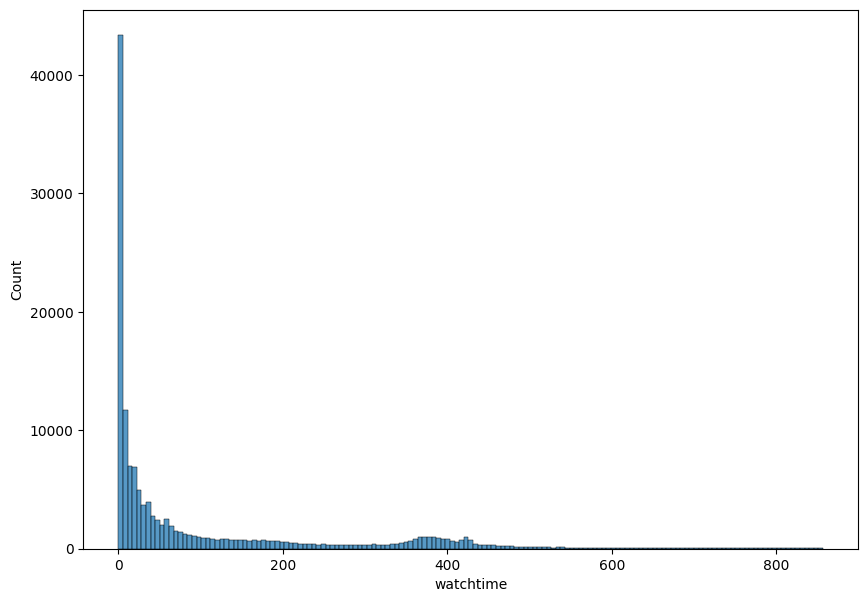

In [16]:
df_watchtime_agg_wo_outlier = df_watchtime_agg[(df_watchtime_agg['watchtime']<np.percentile(df_watchtime_agg['watchtime'],95))]
plt.figure(figsize=(10,7))
sns.histplot(data = df_watchtime_agg_wo_outlier,x='watchtime')
plt.show()

In [17]:
ttl_users = math.ceil(df_watchtime_agg_wo_outlier['device_id'].nunique() * namespace * gb_split / num_of_bucket)
var = df_watchtime_agg_wo_outlier['watchtime'].var()
mean = df_watchtime_agg_wo_outlier['watchtime'].mean()
mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean

print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Средний watchtime за неделю:',round(mean,4))
print('Дисперсия',round(var,4)) 
print('Число пользователей',math.ceil(ttl_users))

MDE абсолютный: 3.2727
MDE относительный: 0.0299
Средний watchtime за неделю: 109.5168
Дисперсия 26903.3663
Число пользователей 39431


In [18]:
# Проверка
def estimate_sample_size(effect, var, alpha, beta):
    """Оценка необходимого размер групп."""
    t_alpha = stats.norm.ppf(1 - alpha /(num_of_bucket - 1) / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    var = 2 * var 
    sample_size = int((t_alpha + t_beta) ** 2 * var / (effect ** 2))
    return sample_size


In [19]:
estimate_sample_size(mde_absolute,var,0.05,0.2)

39431

## Постстратификация + CUPED (только по удержанным)

### Функция для CUPED

### Подготовка датафрейма с предэксперементальной ковариатой (минус 1 неделя)  той же метрики

In [20]:
df_watchtime_pre_1_week_agg = segment(df_watchtime_merge,type = 'Все пользователи',pre_experimental_week = 'required').groupby('device_id')['watchtime'].sum().reset_index()

In [21]:
df_watchtime_agg['new_type'].value_counts(normalize=True)

new_type
Новые         0.543653
Удержанные    0.456347
Name: proportion, dtype: float64

### Объединение целевой метрики и ковариаты

In [22]:
df_watchtime_merge = pd.merge(df_watchtime_agg,df_watchtime_pre_1_week_agg,on='device_id',how='left')
df_watchtime_merge.fillna(0,inplace=True)
df_watchtime_merge.rename(columns = {'watchtime_x':'watchtime_experiment','watchtime_y':'watchtime_pre_experiment'},inplace=True)

# df_watchtime_register_merge['pre_experiment_type'] = np.where(df_watchtime_register_merge['watchtime_pre_experiment'] != 0, 0, 1)

In [23]:
df_watchtime_merge[df_watchtime_merge['watchtime_pre_experiment']==0][:20]

,device_id,os_name,device_manufacturer,country_type,device_model,new_type,app_version_name,watchtime_experiment,watchtime_pre_experiment
0,00005950-1375-30e7-9054-780bd6446bef,1,Huawei,Россия,DUA-LX9,Новые,1.53.0,6.951,0.0
2,00014a36-2e01-354a-a795-96cb689a21fe,1,POCO,Россия,POCO M4 Pro,Новые,1.52.0,135.713,0.0
3,0001e169-973d-3349-b125-8607b67e8dee,1,Samsung,Россия,Galaxy A03,Новые,1.53.0,61.675,0.0
4,0001e7b6-ce91-32fb-840e-1f2e49b26eef,1,Huawei,Россия,BTK-W09,Новые,1.53.0,34.371,0.0
5,00026be7-4d02-327c-92b7-17dd7f20dc6c,1,Redmi,Россия,Redmi Note 10 Pro,Удержанные,1.46.0,21.201,0.0
7,0003f3d1-e483-310c-9ab7-beb53ebd5b0b,1,Xiaomi,Россия,Xiaomi Pad 6,Удержанные,1.50.1,1.151,0.0
8,000417d7-b3d3-3842-9a06-d17175771d9b,1,POCO,Россия,POCO M4 5G,Удержанные,1.50.1,0.000,0.0
9,00046281-b84e-3ea0-956b-36604984b8e3,1,Redmi,Россия,Redmi 9A,Новые,1.52.0,0.000,0.0
10,0004d030-7c96-3d9b-b456-a421dd4cff07,1,POCO,Россия,POCO X3 Pro,Удержанные,1.50.1,0.109,0.0
11,0004eebe-dec3-3b7f-a118-2801521e7ca9,1,Redmi,Россия,Redmi Note 12,Новые,1.52.0,1.936,0.0


In [24]:
df_watchtime_agg_wo_outlier = df_watchtime_agg[(df_watchtime_agg['watchtime']<np.percentile(df_watchtime_agg['watchtime'],95))]
df_watchtime_pre_1_week_agg_wo_oultier =  df_watchtime_pre_1_week_agg[(df_watchtime_pre_1_week_agg['watchtime']<np.percentile(df_watchtime_pre_1_week_agg['watchtime'],95))]


df_watchtime_merge_wo_oultier = pd.merge(df_watchtime_agg_wo_outlier,df_watchtime_pre_1_week_agg_wo_oultier,on='device_id',how='left')
df_watchtime_merge_wo_oultier.fillna(0,inplace=True)
df_watchtime_merge_wo_oultier.rename(columns = {'watchtime_x':'watchtime_experiment','watchtime_y':'watchtime_pre_experiment'},inplace=True)

### Функция для расчета CUPED и Постратификации 

In [25]:
def calculate_theta(y_control, y_pilot, x_control, x_pilot):
    """Вычисляем Theta по данным двух групп """
    y = np.hstack([y_control, y_pilot])
    x = np.hstack([x_control, x_pilot])
    covariance = np.cov(x, y)[0, 1]
    variance = x.var()
    theta = covariance / variance
    return theta 

In [26]:
ttl_users = math.ceil(df_watchtime_agg['device_id'].nunique() * namespace * gb_split / num_of_bucket)
df_control_wo_outlier_strat_cuped = df_watchtime_merge_wo_oultier.sample(n=ttl_users, replace=True)
df_pilot_wo_outlier_strat_cuped = df_watchtime_merge_wo_oultier.sample(n=ttl_users, replace=True)

theta = calculate_theta (
                        df_control_wo_outlier_strat_cuped[df_control_wo_outlier_strat_cuped['new_type']=='Удержанные']['watchtime_experiment'], df_pilot_wo_outlier_strat_cuped[df_pilot_wo_outlier_strat_cuped['new_type']=='Удержанные']['watchtime_experiment'],
                        df_control_wo_outlier_strat_cuped[df_control_wo_outlier_strat_cuped['new_type']=='Удержанные']['watchtime_pre_experiment'], df_pilot_wo_outlier_strat_cuped[df_pilot_wo_outlier_strat_cuped['new_type']=='Удержанные']['watchtime_pre_experiment']
                        )

print(f'theta = {theta}')

theta = 0.3040453166121646


100%|██████████| 1000/1000 [00:01<00:00, 693.87it/s]


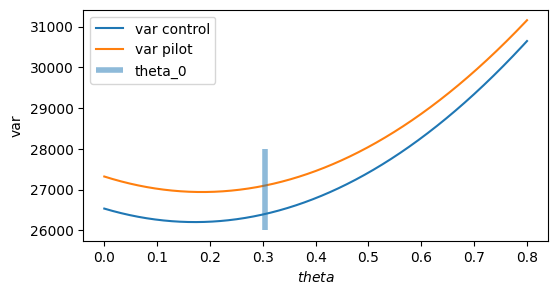

In [27]:
plt.figure(figsize=(6,3))
thetas = np.linspace(0.0, 0.8, 1000)
list_var_control = []
list_var_pilot = []
df_control_wo_outlier = df_watchtime_merge_wo_oultier.sample(n = ttl_users,replace=True)
df_pilot_wo_outlier = df_watchtime_merge_wo_oultier.sample(n = ttl_users,replace=True)


for theta_ in tqdm(thetas):
    y_cuped_control = df_control_wo_outlier['watchtime_experiment'] - theta_ * df_control_wo_outlier['watchtime_pre_experiment']
    y_cuped_pilot = df_pilot_wo_outlier['watchtime_experiment'] - theta_ * df_pilot_wo_outlier['watchtime_pre_experiment']
    list_var_control.append(y_cuped_control.var())
    list_var_pilot.append(y_cuped_pilot.var())

plt.plot(thetas, list_var_control, label='var control')
plt.plot(thetas, list_var_pilot, label='var pilot')
plt.vlines(theta, 26000, 28000, label='theta_0', linewidth=4, alpha=0.5)
plt.xlabel('$theta$')
plt.ylabel('var')
plt.legend()
plt.show()

In [28]:
def check_cuped_test(df_control, df_pilot):
    """Проверяет гипотезу о равенстве средних с использованием CUPED.

    covariate_column - название стобца с ковариантой

    return - pvalue.
    """
    theta = calculate_theta(
    df_control[df_control['new_type']=='Удержанные']['watchtime_experiment'], df_pilot[df_pilot['new_type']=='Удержанные']['watchtime_experiment'],
    df_control[df_control['new_type']=='Удержанные']['watchtime_pre_experiment'], df_pilot[df_pilot['new_type']=='Удержанные']['watchtime_pre_experiment']
    )
     
    df_pilot['watchtime_cuped'] = df_pilot['watchtime_experiment'] - theta * df_pilot['watchtime_pre_experiment']
    df_control['watchtime_cuped'] = df_control['watchtime_experiment'] - theta * df_control['watchtime_pre_experiment']
    var = df_pilot['watchtime_cuped'].var()
    _, pvalue = stats.ttest_ind(df_pilot['watchtime_cuped'], df_control['watchtime_cuped'])
    return pvalue,var

In [29]:
def calculate_strat_var(df, weights, covariate_column):
    """Вычисляет стратифицированную дисперсию."""
    strat_vars = df.groupby('device_model')[covariate_column].var()
    df_vars_weights = pd.merge(
        strat_vars,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_vars_weights['weight'] = df_vars_weights['weight'] / df_vars_weights['weight'].sum()
    var_strat = (df_vars_weights['weight'] * df_vars_weights[covariate_column]).sum()
    return var_strat

In [30]:
def calculate_stratified_mean(df, weights, covariate_column):
    """Вычисляет стратифицированное среднее.

    df - датафрейм с целевой метрикой и данными для стратификации
    weights - словарь - {название страты: вес страты}

    return: float, mean_strat
    """
    strat_mean = df.groupby('device_model')[covariate_column].mean()
    df_means_weights = pd.merge(
        strat_mean,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights[covariate_column]).sum()
    return mean_strat

In [31]:
def check_stratified_test(df_control, df_pilot, weights,covariate_column):
    """Проверяет гипотезу о равенстве средних для стратифицированного среднего.
    
    return - pvalue.
    """
    theta = calculate_theta(
    df_control[df_control['new_type']=='Удержанные']['watchtime_experiment'], df_pilot[df_pilot['new_type']=='Удержанные']['watchtime_experiment'],
    df_control[df_control['new_type']=='Удержанные']['watchtime_pre_experiment'], df_pilot[df_pilot['new_type']=='Удержанные']['watchtime_pre_experiment']
    )

    df_pilot['watchtime_cuped'] = df_pilot['watchtime_experiment'] - theta * df_pilot['watchtime_pre_experiment']
    df_control['watchtime_cuped'] = df_control['watchtime_experiment'] - theta * df_control['watchtime_pre_experiment']
    
    mean_strat_control = calculate_stratified_mean(df_control, weights, covariate_column)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights, covariate_column)
    var_strat_control = calculate_strat_var(df_control, weights, covariate_column)
    var_strat_pilot = calculate_strat_var(df_pilot, weights,covariate_column)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue,var_strat_control

In [32]:
def check_stratified_cuped_test(df_control, df_pilot, weights,covariate_column):
    """Проверяет гипотезу о равенстве средних для стратифицированного среднего.
    
    return - pvalue.
    """
    theta = calculate_theta(
    df_control[df_control['new_type']=='Удержанные']['watchtime_experiment'], df_pilot[df_pilot['new_type']=='Удержанные']['watchtime_experiment'],
    df_control[df_control['new_type']=='Удержанные']['watchtime_pre_experiment'], df_pilot[df_pilot['new_type']=='Удержанные']['watchtime_pre_experiment']
    )
     

    df_pilot['watchtime_cuped'] = df_pilot['watchtime_experiment'] - theta * df_pilot['watchtime_pre_experiment']
    df_control['watchtime_cuped'] = df_control['watchtime_experiment'] - theta * df_control['watchtime_pre_experiment']
    
    mean_strat_control = calculate_stratified_mean(df_control, weights,covariate_column)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights,covariate_column)
    var_strat_control = calculate_strat_var(df_control, weights,covariate_column)
    var_strat_pilot = calculate_strat_var(df_pilot, weights,covariate_column)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue,var_strat_control,mean_strat_pilot

## Симмуляция Монте-Карло АА-теста 

100%|██████████| 1000/1000 [02:57<00:00,  5.62it/s]


Среднее значение выборочных дисперсий без выбросов: 26913.320005676298
Среднее значение выборочных дисперсий без выбросов с применением постратификации: 21556.31939968235
Среднее значение выборочных дисперсий без выбросов с применением CUPED: 26711.963398143336
Среднее значение выборочных дисперсий без выбросов с применением CUPED и постстратификации: 21901.192695308375

Среднее значение выборочных средних без выбросов: 109.53366924668724
Среднее значение выборочных средних без выбросов c применение CUPED и постстратификации : 108.30851124990903


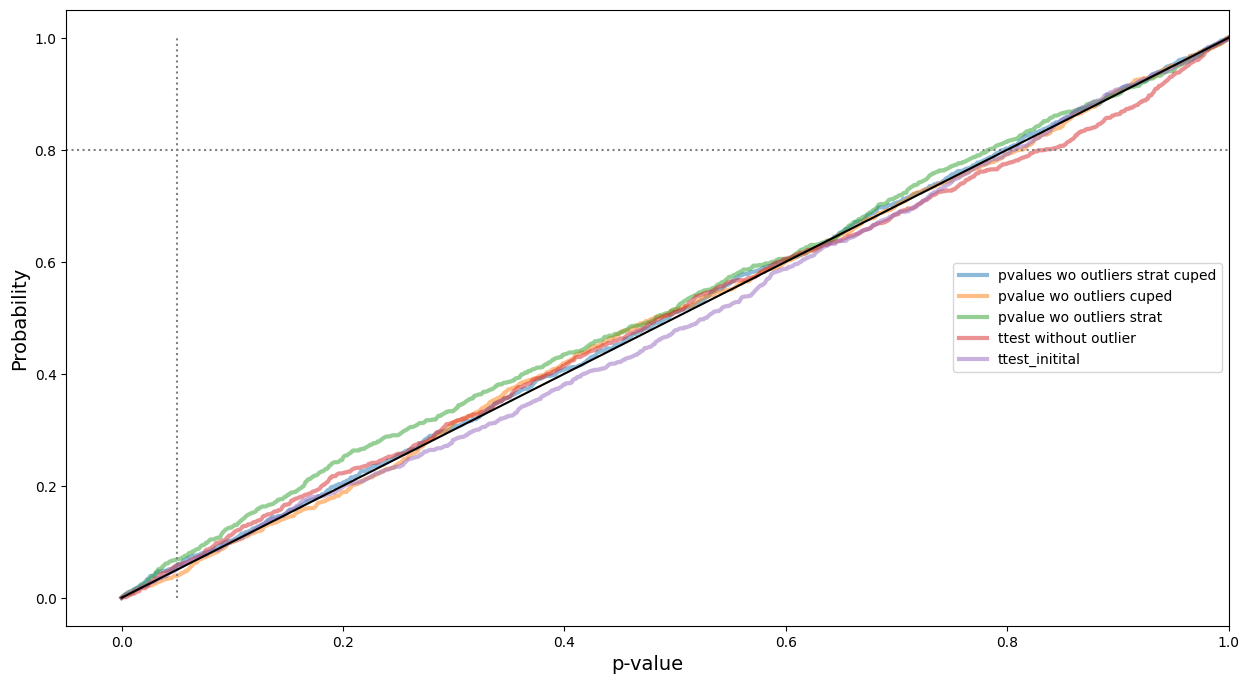

In [34]:
weights = df_watchtime_2['device_model'].value_counts(normalize=True).to_dict()

ttl_users_1 = math.ceil(df_watchtime_2['device_id'].nunique() * namespace * gb_split / num_of_bucket)
ttl_users_2 = math.ceil(df_watchtime_agg['device_id'].nunique() * namespace * gb_split / num_of_bucket)

covariate_column='watchtime_experiment'
covariate_column2='watchtime_cuped'

effect = 0

pvalues_ttest = []
pvalues_wo_outliers = []
pvalues_wo_outliers_strat = []
pvalues_wo_outliers_cuped = []
pvalues_wo_outliers_strat_cuped = []

var_wo_outliers = []
var_wo_outliers_strat = []
var_wo_outliers_cuped = []
var_wo_outliers_strat_cuped = []

mean_wo_ouliers = []
mean_wo_outliers_strat_cuped = []


for i in tqdm(range(1000)):
    
        df_control = df_watchtime_agg.sample(n=ttl_users_1,replace=True)
        df_pilot = df_watchtime_agg.sample(n=ttl_users_1,replace=True)
        df_pilot['watchtime'] += effect
        pvalue = stats.ttest_ind(df_control['watchtime'], df_pilot['watchtime'])[1]
        
        
        df_control_wo_outlier = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2,replace=True)
        df_pilot_wo_outlier = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2,replace=True)
        df_pilot_wo_outlier['watchtime_experiment'] += effect
        var = df_pilot_wo_outlier['watchtime_experiment'].var()
        pvalue_wo_outliers = stats.ttest_ind(df_control_wo_outlier['watchtime_experiment'], df_pilot_wo_outlier['watchtime_experiment'])[1]

        
        df_control_wo_outlier_strat = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2, replace=True)
        df_pilot_wo_outlier_strat = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2, replace=True)
        df_pilot_wo_outlier_strat['watchtime_experiment'] += effect
        means_wo_ouliers = df_pilot_wo_outlier_strat['watchtime_experiment'].mean()
        pvalue_wo_outlier_strat = check_stratified_test(df_control_wo_outlier_strat, df_pilot_wo_outlier_strat, weights,covariate_column=covariate_column)
        
        
        df_control_wo_outlier_cuped = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2, replace=True)
        df_pilot_wo_outlier_cuped = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2, replace=True)
        df_pilot_wo_outlier_cuped['watchtime_experiment'] += effect
        pvalue_wo_outlier_cuped = check_cuped_test(df_control_wo_outlier_cuped, df_pilot_wo_outlier_cuped)
        
        df_control_wo_outlier_strat_cuped = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2, replace=True)
        df_pilot_wo_outlier_strat_cuped = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2, replace=True)
        df_pilot_wo_outlier_strat_cuped['watchtime_experiment'] += effect
        pvalue_wo_outlier_strat_cuped = check_stratified_cuped_test(df_control_wo_outlier_strat_cuped, df_pilot_wo_outlier_strat_cuped, weights,covariate_column=covariate_column2)
        
        pvalues_ttest.append(pvalue)
        pvalues_wo_outliers.append(pvalue_wo_outliers)
        pvalues_wo_outliers_strat.append(pvalue_wo_outlier_strat[0])
        pvalues_wo_outliers_cuped.append(pvalue_wo_outlier_cuped[0])
        pvalues_wo_outliers_strat_cuped.append(pvalue_wo_outlier_strat_cuped[0])
        
        var_wo_outliers.append(var)
        var_wo_outliers_strat.append(pvalue_wo_outlier_strat[1])
        var_wo_outliers_cuped.append(pvalue_wo_outlier_cuped[1])
        var_wo_outliers_strat_cuped.append(pvalue_wo_outlier_strat_cuped[1])
        
        mean_wo_ouliers.append(means_wo_ouliers)
        mean_wo_outliers_strat_cuped.append(pvalue_wo_outlier_strat_cuped[2])

list_pvalues = [pvalues_ttest, pvalues_wo_outliers,pvalues_wo_outliers_strat,pvalues_wo_outliers_cuped,pvalues_wo_outliers_strat_cuped]
list_titles = ['ttest_initital', 'ttest without outlier','pvalue wo outliers strat','pvalue wo outliers cuped','pvalues wo outliers strat cuped']

print("Среднее значение выборочных дисперсий без выбросов:",np.mean(var_wo_outliers))
print("Среднее значение выборочных дисперсий без выбросов с применением постратификации:",np.mean(var_wo_outliers_strat))
print("Среднее значение выборочных дисперсий без выбросов с применением CUPED:",np.mean(var_wo_outliers_cuped))
print("Среднее значение выборочных дисперсий без выбросов с применением CUPED и постстратификации:",np.mean(var_wo_outliers_strat_cuped))   
print()
print("Среднее значение выборочных средних без выбросов:",np.mean(mean_wo_ouliers))
print("Среднее значение выборочных средних без выбросов c применение CUPED и постстратификации :",np.mean(mean_wo_outliers_strat_cuped))

plt.figure(figsize=(15,8))

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
x_values = [0.05]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.xlabel('p-value', size=14)
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

## Симуляция Монте-Карло АB теста

100%|██████████| 5000/5000 [16:01<00:00,  5.20it/s]


Среднее значение выборочных дисперсий без выбросов: 26902.332886938464
Среднее значение выборочных дисперсий без выбросов с применением постратификации: 21544.118473978866
Среднее значение выборочных дисперсий без выбросов с применением CUPED: 26711.949921487805
Среднее значение выборочных дисперсий без выбросов с применением CUPED и постстратификации: 21909.444626926368

Среднее значение выборочных средних без выбросов: 112.79576361465813
Среднее значение выборочных средних без выбросов c применение CUPED и постстратификации : 111.61799700165707


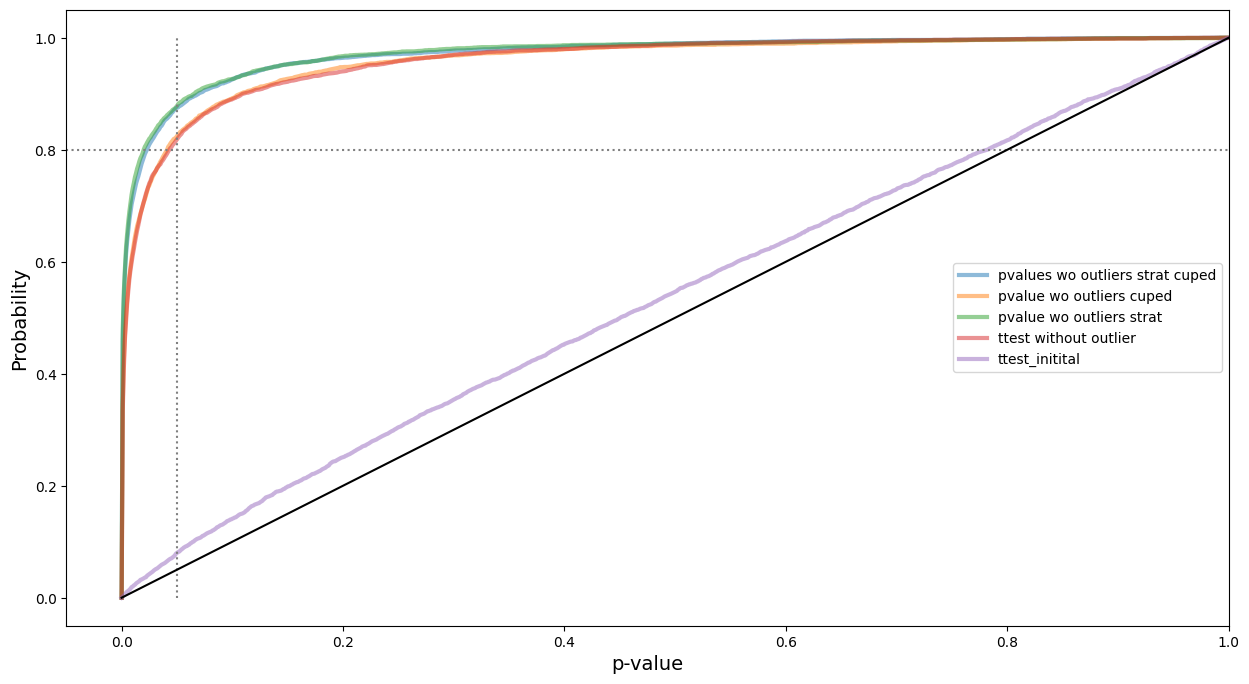

In [38]:
weights = df_watchtime_2['device_model'].value_counts(normalize=True).to_dict()

ttl_users_1 = math.ceil(df_watchtime_2['device_id'].nunique() * namespace * gb_split / num_of_bucket)
ttl_users_2 = math.ceil(df_watchtime_agg['device_id'].nunique() * namespace * gb_split / num_of_bucket)

covariate_column='watchtime_experiment'
covariate_column2='watchtime_cuped'

effect = 3.2733

pvalues_ttest = []
pvalues_wo_outliers = []
pvalues_wo_outliers_strat = []
pvalues_wo_outliers_cuped = []
pvalues_wo_outliers_strat_cuped = []

var_wo_outliers = []
var_wo_outliers_strat = []
var_wo_outliers_cuped = []
var_wo_outliers_strat_cuped = []

mean_wo_ouliers = []
mean_wo_outliers_strat_cuped = []


for i in tqdm(range(5000)):
    
        df_control = df_watchtime_agg.sample(n=ttl_users_1,replace=True)
        df_pilot = df_watchtime_agg.sample(n=ttl_users_1,replace=True)
        df_pilot['watchtime'] += effect
        pvalue = stats.ttest_ind(df_control['watchtime'], df_pilot['watchtime'])[1]
        
        
        df_control_wo_outlier = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2,replace=True)
        df_pilot_wo_outlier = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2,replace=True)
        df_pilot_wo_outlier['watchtime_experiment'] += effect
        var = df_pilot_wo_outlier['watchtime_experiment'].var()
        pvalue_wo_outliers = stats.ttest_ind(df_control_wo_outlier['watchtime_experiment'], df_pilot_wo_outlier['watchtime_experiment'])[1]

        
        df_control_wo_outlier_strat = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2, replace=True)
        df_pilot_wo_outlier_strat = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2, replace=True)
        df_pilot_wo_outlier_strat['watchtime_experiment'] += effect
        means_wo_ouliers = df_pilot_wo_outlier_strat['watchtime_experiment'].mean()
        pvalue_wo_outlier_strat = check_stratified_test(df_control_wo_outlier_strat, df_pilot_wo_outlier_strat, weights,covariate_column=covariate_column)
        
        
        df_control_wo_outlier_cuped = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2, replace=True)
        df_pilot_wo_outlier_cuped = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2, replace=True)
        df_pilot_wo_outlier_cuped['watchtime_experiment'] += effect
        pvalue_wo_outlier_cuped = check_cuped_test(df_control_wo_outlier_cuped, df_pilot_wo_outlier_cuped)
        
        df_control_wo_outlier_strat_cuped = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2, replace=True)
        df_pilot_wo_outlier_strat_cuped = df_watchtime_merge_wo_oultier.sample(n=ttl_users_2, replace=True)
        df_pilot_wo_outlier_strat_cuped['watchtime_experiment'] += effect
        pvalue_wo_outlier_strat_cuped = check_stratified_cuped_test(df_control_wo_outlier_strat_cuped, df_pilot_wo_outlier_strat_cuped, weights,covariate_column=covariate_column2)
        
        pvalues_ttest.append(pvalue)
        pvalues_wo_outliers.append(pvalue_wo_outliers)
        pvalues_wo_outliers_strat.append(pvalue_wo_outlier_strat[0])
        pvalues_wo_outliers_cuped.append(pvalue_wo_outlier_cuped[0])
        pvalues_wo_outliers_strat_cuped.append(pvalue_wo_outlier_strat_cuped[0])
        
        var_wo_outliers.append(var)
        var_wo_outliers_strat.append(pvalue_wo_outlier_strat[1])
        var_wo_outliers_cuped.append(pvalue_wo_outlier_cuped[1])
        var_wo_outliers_strat_cuped.append(pvalue_wo_outlier_strat_cuped[1])
        
        mean_wo_ouliers.append(means_wo_ouliers)
        mean_wo_outliers_strat_cuped.append(pvalue_wo_outlier_strat_cuped[2])

list_pvalues = [pvalues_ttest, pvalues_wo_outliers,pvalues_wo_outliers_strat,pvalues_wo_outliers_cuped,pvalues_wo_outliers_strat_cuped]
list_titles = ['ttest_initital', 'ttest without outlier','pvalue wo outliers strat','pvalue wo outliers cuped','pvalues wo outliers strat cuped']

print("Среднее значение выборочных дисперсий без выбросов:",np.mean(var_wo_outliers))
print("Среднее значение выборочных дисперсий без выбросов с применением постратификации:",np.mean(var_wo_outliers_strat))
print("Среднее значение выборочных дисперсий без выбросов с применением CUPED:",np.mean(var_wo_outliers_cuped))
print("Среднее значение выборочных дисперсий без выбросов с применением CUPED и постстратификации:",np.mean(var_wo_outliers_strat_cuped))   
print()
print("Среднее значение выборочных средних без выбросов:",np.mean(mean_wo_ouliers))
print("Среднее значение выборочных средних без выбросов c применение CUPED и постстратификации :",np.mean(mean_wo_outliers_strat_cuped))

plt.figure(figsize=(15,8))

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
x_values = [0.05]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.xlabel('p-value', size=14)
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

## Итоговые результаты

### Без удаления выбросов

In [35]:
ttl_users = math.ceil(df_watchtime_agg['device_id'].nunique() * namespace * gb_split / num_of_bucket)
var = df_watchtime_agg['watchtime'].var()
mean = df_watchtime_agg['watchtime'].mean()

mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean

print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Средний watchtime за неделю:',round(mean,4))
print('Дисперсия',round(var,4)) 
print('Число пользователей',math.ceil(ttl_users))

MDE абсолютный: 20.9108
MDE относительный: 0.0815
Средний watchtime за неделю: 256.6314
Дисперсия 1156149.2207
Число пользователей 41506


### Удаление выбросов 

In [36]:
ttl_users = math.ceil(df_watchtime_agg_wo_outlier['device_id'].nunique() * namespace * gb_split / num_of_bucket)
var = np.mean(var_wo_outliers)
mean = np.mean(mean_wo_ouliers)
mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean

print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Средний watchtime за неделю:',round(mean,4))
print('Дисперсия',round(var,4)) 
print('Число пользователей',math.ceil(ttl_users))

MDE абсолютный: 3.2733
MDE относительный: 0.0299
Средний watchtime за неделю: 109.5337
Дисперсия 26913.32
Число пользователей 39431


### Удаление выбросов и CUPED + постстратификация

In [37]:
ttl_users = math.ceil(df_watchtime_agg_wo_outlier['device_id'].nunique() * namespace * gb_split / num_of_bucket)
var = np.mean(var_wo_outliers_strat_cuped)
mean = np.mean(mean_wo_outliers_strat_cuped)
mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean

print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Средний watchtime за неделю:',round(mean,4))
print('Дисперсия',round(var,4)) 
print('Число пользователей',math.ceil(ttl_users))

MDE абсолютный: 2.9528
MDE относительный: 0.0273
Средний watchtime за неделю: 108.3085
Дисперсия 21901.1927
Число пользователей 39431
